# <span style="color:#FFF9C1">Clustering 5000 Songs</span> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.cm import get_cmap

# <span style="color:#6FFFE9">importing csv data </span>

In [2]:
df_song = pd.read_csv('./df_audio_features_5000')
df_song.columns = df_song.columns.str.strip()

#make a copy
song_df = df_song.copy()

In [3]:
#drop duplicates
song_df = song_df.drop_duplicates()
song_df.shape

(5175, 18)

In [ ]:
song_df["id"].nunique()

5171

In [4]:
#duplicated_rows = song_df[song_df.duplicated(subset=['id'])]
song_df.drop_duplicates(subset=['id'], keep='first', inplace=True)
song_df.shape

(5171, 18)

# <span style="color:#6FFFE9">Selecting Data Columns</span>

In [5]:
song = (song_df
        .set_index('id')
        .filter([
                'danceability', 'energy', 'speechiness', 'acousticness', 
                'instrumentalness', 'valence', 'tempo'
                ])
       )

song.sample(5)

,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo
id,,,,,,,
5pqF0qKSQCEq5mt5CFEXoq,0.733,0.751,0.0828,0.6310,0.000000,0.701,126.018
2XU0oxnq2qxCpomAAuJY8K,0.824,0.588,0.0924,0.6920,0.000104,0.513,98.027
2q4rjDy9WhaN3o9MvDbO21,0.758,0.712,0.1120,0.0185,0.000000,0.795,149.998
4lLtanYk6tkMvooU0tWzG8,0.704,0.558,0.0542,0.1480,0.000000,0.245,110.444
4vDEkER6ToECKrxiPzE2Tp,0.625,0.852,0.0341,0.6920,0.000487,0.931,82.142


# <span style="color:#6FFFE9">KMeans</span>

## <span style="color:#ffadad">n_cluster = 10</span> 

In [ ]:
# create 20 clusters
kmeans = KMeans(n_clusters=10)

# fit the model
kmeans.fit(song)

# create a column with the cluster labels
song['cluster'] = kmeans.labels_

song.head()

## <span style="color:#ffadad">inertia</span>

In [7]:
kmeans.inertia_

77987.42895773606

In [ ]:
max_k = 20
inertia = []

for k in range(1, max_k+1): 
    inertia.append(KMeans(n_clusters=k).fit(song).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k+1), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xticks(np.arange(0, 21, 2))
#ax.set_xlim([2, 8])
plt.show()

## <span style="color:#ffadad">silhouette score</span>

In [9]:
silhouette_score(song, kmeans.labels_)

0.5979343586322545

In [ ]:
scaled_features = song
def get_silhouette_score(k, features):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
    labels = kmeans.labels_
    score = silhouette_score(features, labels)
    return score

# Calculate silhouette scores for different k values
k_values = list(range(2, 15))
silhouette_scores = [get_silhouette_score(k, scaled_features) for k in k_values]

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for 5000 songs Dataset")
plt.show()


def plot_silhouette_scores(k, features):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
    labels = kmeans.labels_
    score = silhouette_score(features, labels)

    # Compute silhouette scores for each sample
    sample_scores = silhouette_samples(features, labels)

    fig, ax = plt.subplots()
    y_lower = 10
    cmap = get_cmap("viridis")

    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to the same cluster and sort them
        ith_cluster_silhouette_values = sample_scores[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    ax.set_title("Silhouette Scores for 5000 songs Dataset with k = {}".format(k))
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the y-axis labels
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# Visualize the silhouette scores for different k values
for k in range(2, 15):
    plot_silhouette_scores(k, scaled_features)

## <span style="color:#ffadad">centroid dataframe</span>

In [11]:
song_dc = song.drop(columns='cluster')
song_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=song_dc.columns)
song_centroids = song_centroids.rename(columns=lambda x: x + '_centroid')
song_centroids = song_centroids.reset_index().rename(columns={'index': 'cluster'})

# rename {col} to {col}_centroid
song_centroids

,cluster,danceability_centroid,energy_centroid,speechiness_centroid,acousticness_centroid,instrumentalness_centroid,valence_centroid,tempo_centroid
0,0,0.311370,0.239360,0.063685,0.770230,0.625040,0.195360,68.439613
1,1,0.556932,0.681072,0.075459,0.249758,0.224723,0.485397,118.473357
2,2,0.428585,0.686214,0.107264,0.278376,0.270763,0.469077,173.587581
3,3,0.473846,0.637006,0.073117,0.311957,0.264196,0.408194,140.479430
4,4,0.438665,0.738035,0.092966,0.211413,0.288059,0.458694,155.032946
5,5,0.575720,0.678796,0.095961,0.275796,0.196527,0.503097,94.964481
6,6,0.579623,0.722692,0.072526,0.191420,0.212005,0.456632,128.073124
7,7,0.416774,0.505221,0.082987,0.466402,0.320974,0.367222,81.669568
8,8,0.515863,0.689103,0.080838,0.237520,0.263302,0.430645,106.763008
9,9,0.411144,0.695860,0.126185,0.280843,0.231825,0.534593,193.332826


### <span style="color:#33FFCC">Merge the song and song_controids dataframe</span> 

In [12]:
song_with_centroids = (song.merge(song_centroids, on='cluster', how='left'))
song_with_centroids['id'] = song.index
song_with_centroids = song_with_centroids.set_index('id')
song_with_centroids.head()

,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,cluster,danceability_centroid,energy_centroid,speechiness_centroid,acousticness_centroid,instrumentalness_centroid,valence_centroid,tempo_centroid
id,,,,,,,,,,,,,,,
1n7JnwviZ7zf0LR1tcGFq7,0.658,0.2590,0.0705,0.694,0.000059,0.306,110.376,8,0.515863,0.689103,0.080838,0.237520,0.263302,0.430645,106.763008
5QGM1U0eCYrQuwSJwTm5Zq,0.742,0.3990,0.0346,0.217,0.000002,0.693,125.039,6,0.579623,0.722692,0.072526,0.191420,0.212005,0.456632,128.073124
0NLIFSZxPzQhCwnkn5PJYs,0.851,0.7300,0.3470,0.453,0.000063,0.905,93.698,5,0.575720,0.678796,0.095961,0.275796,0.196527,0.503097,94.964481
3mXqOdlLE1k67WsAxryPFs,0.705,0.0502,0.0471,0.879,0.000041,0.524,106.802,8,0.515863,0.689103,0.080838,0.237520,0.263302,0.430645,106.763008
7bSzjzjTkWT2CkIPPdp0eA,0.651,0.1190,0.0380,0.916,0.000343,0.402,120.941,1,0.556932,0.681072,0.075459,0.249758,0.224723,0.485397,118.473357


### <span style="color:#33FFCC">ploting data</span> 

#### <span style="color:#F1C0E8">tempo vs valence</span>

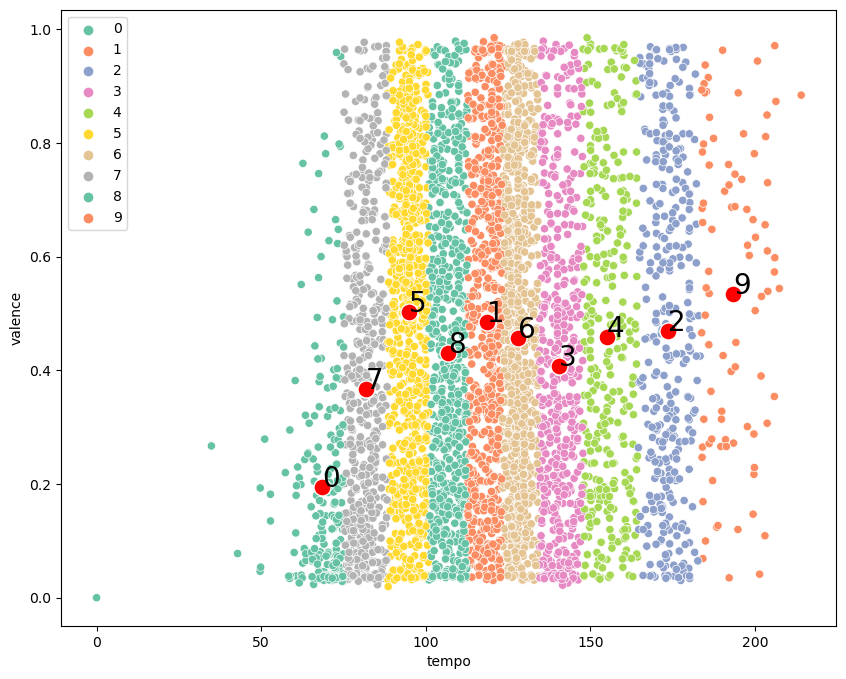

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=song, x='tempo', y='valence', hue='cluster', palette='Set2')
sns.scatterplot(data=song_centroids, x='tempo_centroid', y='valence_centroid', color='red', s=150)
for i in range(song_centroids.shape[0]):
    plt.text(
        x=song_centroids['tempo_centroid'][i], 
        y=song_centroids['valence_centroid'][i],
        s=song_centroids['cluster'][i], 
        size=20
    )
plt.show()

#### <span style="color:#F1C0E8">instrumentalness vs acousticness</span>

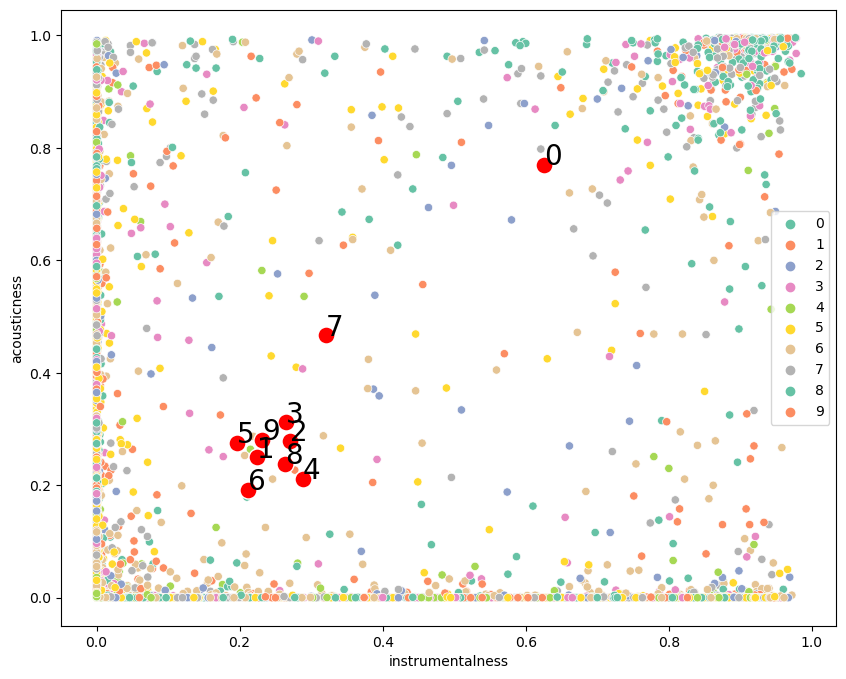

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=song, x='instrumentalness', y='acousticness', hue='cluster', palette='Set2')
sns.scatterplot(data=song_centroids, x='instrumentalness_centroid', y='acousticness_centroid', color='red', s=150)
for i in range(song_centroids.shape[0]):
    plt.text(
        x=song_centroids['instrumentalness_centroid'][i], 
        y=song_centroids['acousticness_centroid'][i],
        s=song_centroids['cluster'][i], 
        size=20
    )
plt.show()

#### <span style="color:#F1C0E8">energy vs acousticness</span>

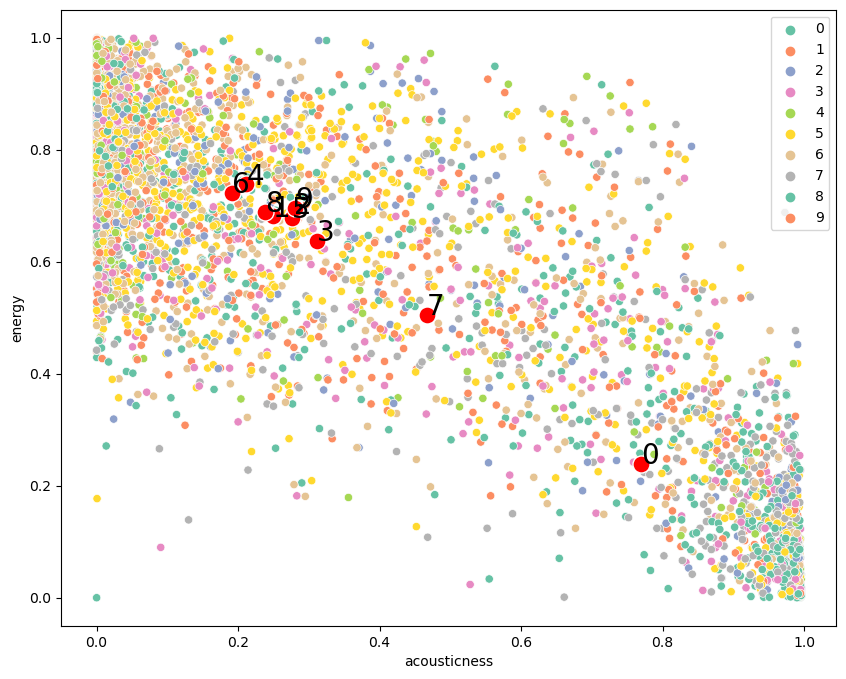

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=song, x='acousticness', y='energy', hue='cluster', palette='Set2')
sns.scatterplot(data=song_centroids, x='acousticness_centroid', y='energy_centroid', color='red', s=150)
for i in range(song_centroids.shape[0]):
    plt.text(
        x=song_centroids['acousticness_centroid'][i], 
        y=song_centroids['energy_centroid'][i],
        s=song_centroids['cluster'][i], 
        size=20
    )
plt.show()

#### <span style="color:#F1C0E8">instrumentalness vs valence</span>

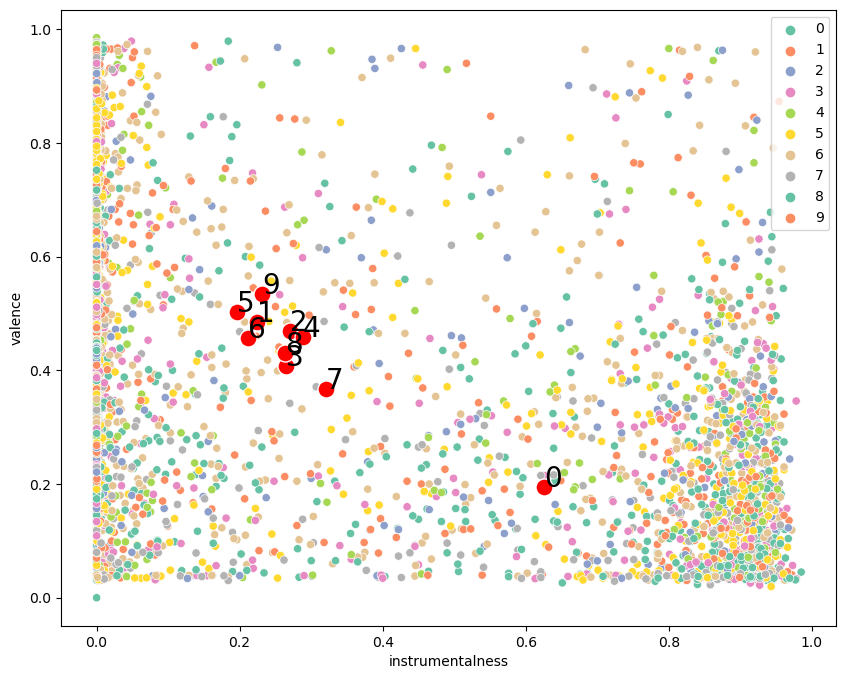

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=song, x='instrumentalness', y='valence', hue='cluster', palette='Set2')
sns.scatterplot(data=song_centroids, x='instrumentalness_centroid', y='valence_centroid', color='red', s=150)
for i in range(song_centroids.shape[0]):
    plt.text(
        x=song_centroids['instrumentalness_centroid'][i], 
        y=song_centroids['valence_centroid'][i],
        s=song_centroids['cluster'][i], 
        size=20
    )
plt.show()

#### <span style="color:#F1C0E8">danceability vs acousticness</span>

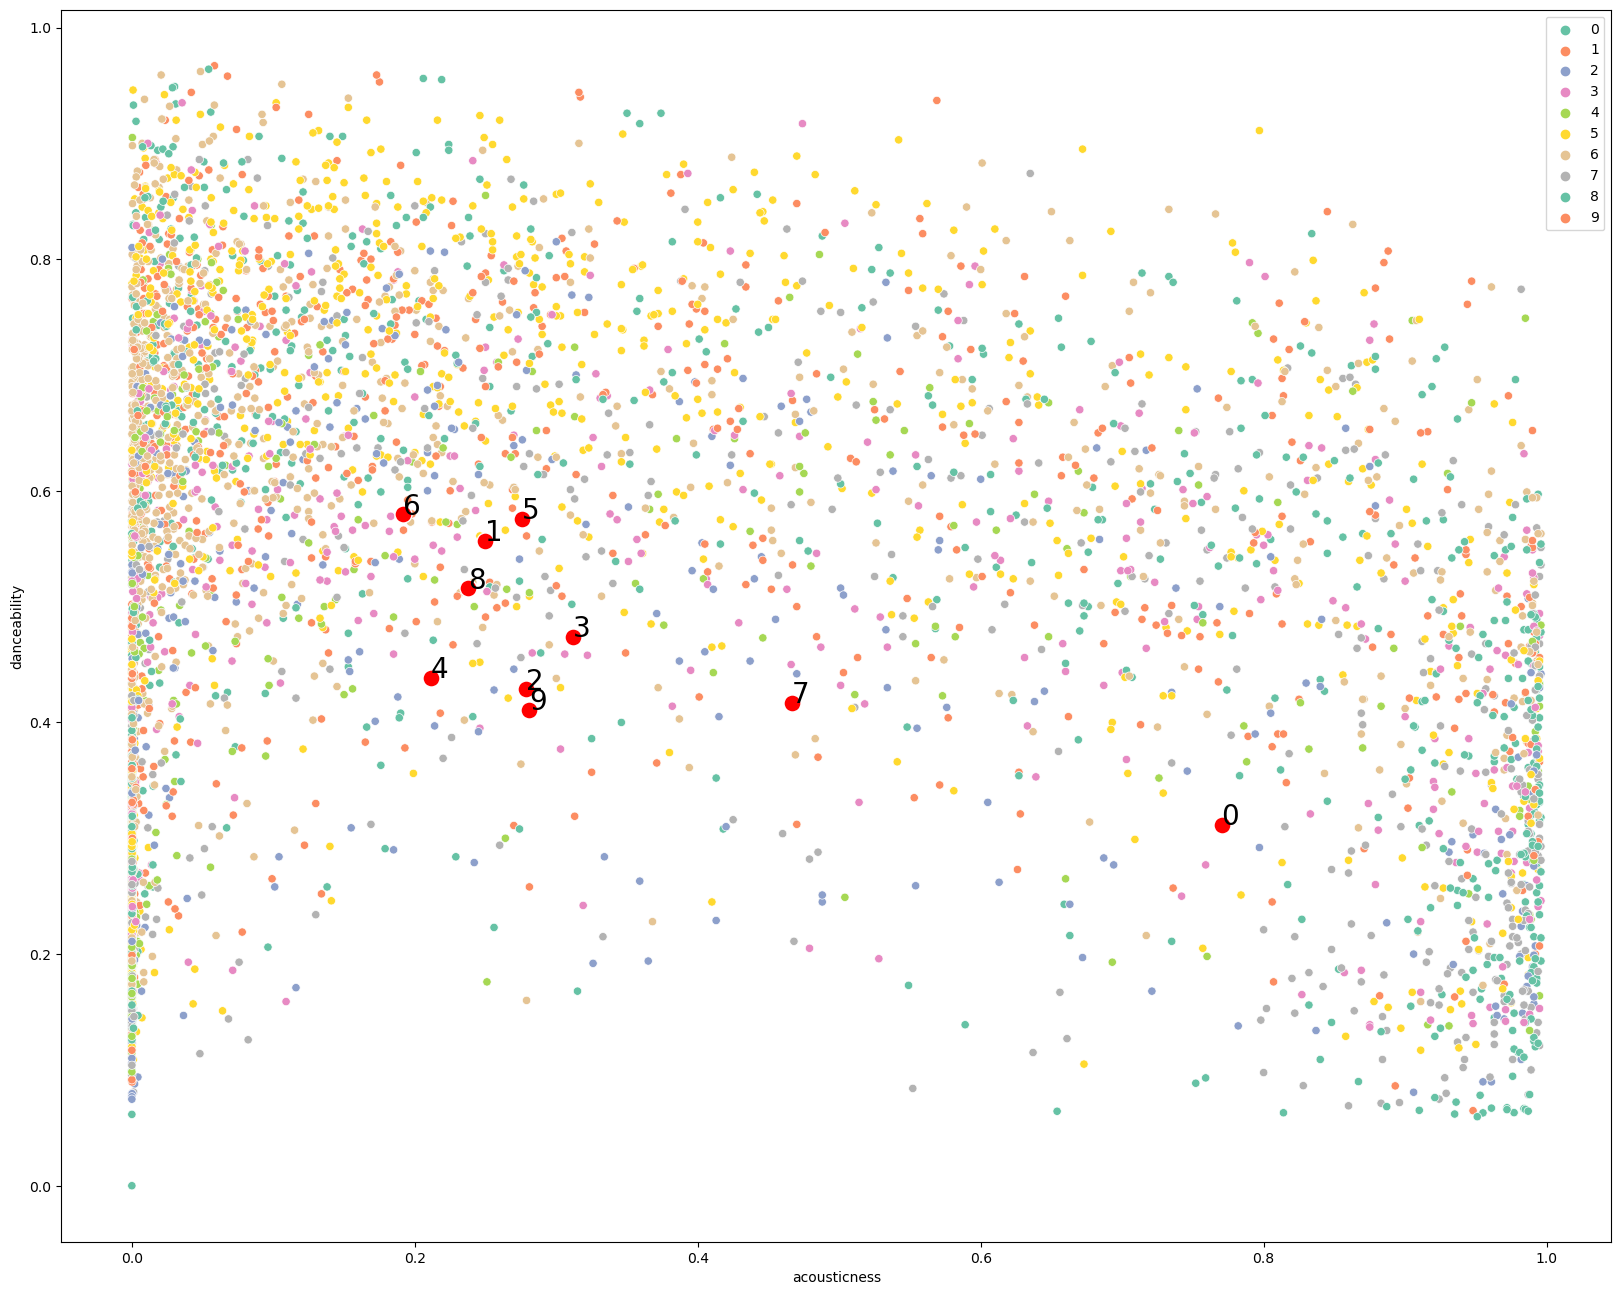

In [17]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.scatterplot(data=song, x='acousticness', y='danceability', hue='cluster', palette='Set2')
sns.scatterplot(data=song_centroids, x='acousticness_centroid', y='danceability_centroid', color='red', s=150)
for i in range(song_centroids.shape[0]):
    plt.text(
        x=song_centroids['acousticness_centroid'][i], 
        y=song_centroids['danceability_centroid'][i],
        s=song_centroids['cluster'][i], 
        size=20
    )
plt.show()

In [19]:
group_song = (
song_with_centroids
    .assign(
        distance = lambda x: (x['acousticness'] - x['acousticness_centroid'])**2 + (x['danceability'] - x['danceability_centroid'])**2
    )
    .groupby('cluster')
        # get top 20 songs with the smallest distance
    .apply(lambda x: x.nsmallest(30, 'distance'))
)
group_song

danceability  energy  speechiness  \
cluster id                                                           
0       7E1ErYYCn0lYjHODZ1qGuB          0.354  0.0487       0.0323   
        4eHbdreAnSOrDDsFfc4Fpm          0.332  0.2140       0.0349   
        0K9XD6kV0t9JTbk5w5TdUX          0.211  0.1690       0.0367   
        33Y2YALzXqMQtBVSDcHOof          0.351  0.2420       0.0412   
        1J9iVCaEriyoMXpj2XszhU          0.427  0.1140       0.0509   
...                                       ...     ...          ...   
9       1h9P5WJwyvK8OB7O2YiXgp          0.690  0.7100       0.3350   
        2OEQjmvLDOf432MCmrZEss          0.335  0.9260       0.1120   
        55kYRn7VFOM5eZ6c4kkk4s          0.653  0.7580       0.2460   
        5u3l2TONYacJgmRPQVaF9y          0.374  0.9200       0.0501   
        5aAx2yezTd8zXrkmtKl66Z          0.681  0.5940       0.2820   

                                 acousticness  instrumentalness  valence  \
cluster id                                                                 
0       7E1ErYYCn0lYjHODZ1qGuB       0.783000          0.484000   0.2530   
        4eHbdreAnSOrDDsFfc4Fpm       0.845000          0.000006   0.1100   
        0K9XD6kV0t9JTbk5w5TdUX       0.735000          0.936000   0.0466   
        33Y2YALzXqMQtBVSDcHOof       0.900000          0.915000   0.0340   
        1J9iVCaEriyoMXpj2XszhU       0.843000          0.863000   0.1140   
...                                       ...               ...      ...   
9       1h9P5WJwyvK8OB7O2YiXgp       0.250000          0.000000   0.7260   
        2OEQjmvLDOf432MCmrZEss       0.553000          0.002240   0.9440   
        55kYRn7VFOM5eZ6c4kkk4s       0.428000          0.000000   0.5450   
        5u3l2TONYacJgmRPQVaF9y       0.000016          0.026000   0.2780   
        5aAx2yezTd8zXrkmtKl66Z       0.165000          0.000003   0.5350   

                                   tempo  cluster  danceability_centroid  \
cluster id                                                                 
0       7E1ErYYCn0lYjHODZ1qGuB    64.120        0               0.311370   
        4eHbdreAnSOrDDsFfc4Fpm    67.531        0               0.311370   
        0K9XD6kV0t9JTbk5w5TdUX    49.654        0               0.311370   
        33Y2YALzXqMQtBVSDcHOof    58.587        0               0.311370   
        1J9iVCaEriyoMXpj2XszhU    60.484        0               0.311370   
...                                  ...      ...                    ...   
9       1h9P5WJwyvK8OB7O2YiXgp   192.068        9               0.411144   
        2OEQjmvLDOf432MCmrZEss   200.722        9               0.411144   
        55kYRn7VFOM5eZ6c4kkk4s   185.150        9               0.411144   
        5u3l2TONYacJgmRPQVaF9y   191.014        9               0.411144   
        5aAx2yezTd8zXrkmtKl66Z   186.054        9               0.411144   

                                 energy_centroid  speechiness_centroid  \
cluster id                                                               
0       7E1ErYYCn0lYjHODZ1qGuB           0.23936              0.063685   
        4eHbdreAnSOrDDsFfc4Fpm           0.23936              0.063685   
        0K9XD6kV0t9JTbk5w5TdUX           0.23936              0.063685   
        33Y2YALzXqMQtBVSDcHOof           0.23936              0.063685   
        1J9iVCaEriyoMXpj2XszhU           0.23936              0.063685   
...                                          ...                   ...   
9       1h9P5WJwyvK8OB7O2YiXgp           0.69586              0.126185   
        2OEQjmvLDOf432MCmrZEss           0.69586              0.126185   
        55kYRn7VFOM5eZ6c4kkk4s           0.69586              0.126185   
        5u3l2TONYacJgmRPQVaF9y           0.69586              0.126185   
        5aAx2yezTd8zXrkmtKl66Z           0.69586              0.126185   

                                 acousticness_centroid  \
cluster id                                               
0       7E1ErYYCn0lYjHODZ1qGuB                0.770230   
       

`Categroy 1`

In [20]:
cat1 = group_song.loc[group_song["cluster"] == 0,:]
del cat1["cluster"]
cat1= cat1.reset_index()
cat1

,cluster,id,danceability,energy,speechiness,acousticness,instrumentalness,valence,tempo,danceability_centroid,energy_centroid,speechiness_centroid,acousticness_centroid,instrumentalness_centroid,valence_centroid,tempo_centroid,distance
0,0,7E1ErYYCn0lYjHODZ1qGuB,0.354,0.0487,0.0323,0.783,0.484000,0.2530,64.120,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.001980
1,0,4eHbdreAnSOrDDsFfc4Fpm,0.332,0.2140,0.0349,0.845,0.000006,0.1100,67.531,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.006016
2,0,0K9XD6kV0t9JTbk5w5TdUX,0.211,0.1690,0.0367,0.735,0.936000,0.0466,49.654,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.011315
3,0,33Y2YALzXqMQtBVSDcHOof,0.351,0.2420,0.0412,0.900,0.915000,0.0340,58.587,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.018411
4,0,1J9iVCaEriyoMXpj2XszhU,0.427,0.1140,0.0509,0.843,0.863000,0.1140,60.484,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.018666
5,0,585VdqgSkRikAnaaZIlK5I,0.311,0.2280,0.0376,0.910,0.051100,0.2270,71.142,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.019536
6,0,7qoaMWT3eRCKG1RN6dVuOY,0.439,0.6380,0.0307,0.707,0.000000,0.7810,69.570,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.020287
7,0,2fXNIyzcOjc5Otknzsfi2O,0.216,0.5440,0.0431,0.663,0.000000,0.3010,75.017,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.020594
8,0,5uNtaTmigAubx5fLfO92AW,0.437,0.0857,0.0384,0.840,0.641000,0.2060,73.161,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.020651
9,0,5ap0zijdFaVWcKRniRtDEN,0.315,0.2070,0.0343,0.917,0.865000,0.0807,67.906,0.31137,0.23936,0.063685,0.77023,0.62504,0.19536,68.439613,0.021555


In [21]:
cat1= cat1.filter(["id"])
cat1= cat1.merge(song_df,how="inner", on="id")
cat1

,id,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,html
0,7E1ErYYCn0lYjHODZ1qGuB,"Ravel: Boléro, M. 81 ...",Maurice Ravel,0.354,0.0487,5,-24.568,1,0.0323,0.783,0.484000,0.2840,0.2530,64.120,,948787,3,https://open.spotify.com/track/7E1ErYYCn0lYjHO...
1,4eHbdreAnSOrDDsFfc4Fpm,I Will Always Love You ...,Whitney Houston,0.332,0.2140,4,-12.518,1,0.0349,0.845,0.000006,0.0839,0.1100,67.531,,271093,4,https://open.spotify.com/track/4eHbdreAnSOrDDs...
2,0K9XD6kV0t9JTbk5w5TdUX,Sunset Monet ...,Hauschka,0.211,0.1690,0,-21.761,1,0.0367,0.735,0.936000,0.0985,0.0466,49.654,,102227,3,https://open.spotify.com/track/0K9XD6kV0t9JTbk...
3,33Y2YALzXqMQtBVSDcHOof,Aries ...,Iasos,0.351,0.2420,5,-20.020,0,0.0412,0.900,0.915000,0.0984,0.0340,58.587,,91427,4,https://open.spotify.com/track/33Y2YALzXqMQtBV...
4,1J9iVCaEriyoMXpj2XszhU,When Sunny Gets Blue ...,McCoy Tyner,0.427,0.1140,2,-22.546,0,0.0509,0.843,0.863000,0.0966,0.1140,60.484,,282320,4,https://open.spotify.com/track/1J9iVCaEriyoMXp...
5,585VdqgSkRikAnaaZIlK5I,Zamba Del Carnaval ...,Pedro Aznar,0.311,0.2280,2,-16.376,0,0.0376,0.910,0.051100,0.1060,0.2270,71.142,,188267,4,https://open.spotify.com/track/585VdqgSkRikAna...
6,7qoaMWT3eRCKG1RN6dVuOY,Stagger Lee ...,Lloyd Price,0.439,0.6380,3,-6.859,1,0.0307,0.707,0.000000,0.1750,0.7810,69.570,,144627,4,https://open.spotify.com/track/7qoaMWT3eRCKG1R...
7,2fXNIyzcOjc5Otknzsfi2O,I'll Be There (feat. Trey Lorenz) - Live at MT...,Mariah Carey,0.216,0.5440,5,-8.132,1,0.0431,0.663,0.000000,0.8820,0.3010,75.017,,264240,4,https://open.spotify.com/track/2fXNIyzcOjc5Otk...
8,5uNtaTmigAubx5fLfO92AW,For Lena And Lennie ...,Quincy Jones,0.437,0.0857,0,-18.129,1,0.0384,0.840,0.641000,0.0898,0.2060,73.161,,259413,4,https://open.spotify.com/track/5uNtaTmigAubx5f...
9,5ap0zijdFaVWcKRniRtDEN,Chopin Nocturne ...,Marcin,0.315,0.2070,6,-13.640,1,0.0343,0.917,0.865000,0.1110,0.0807,67.906,,276396,3,https://open.spotify.com/track/5ap0zijdFaVWcKR...


In [22]:
cat1= cat1.filter(["id","name","artist","html"])
cat1

,id,name,artist,html
0,7E1ErYYCn0lYjHODZ1qGuB,"Ravel: Boléro, M. 81 ...",Maurice Ravel,https://open.spotify.com/track/7E1ErYYCn0lYjHO...
1,4eHbdreAnSOrDDsFfc4Fpm,I Will Always Love You ...,Whitney Houston,https://open.spotify.com/track/4eHbdreAnSOrDDs...
2,0K9XD6kV0t9JTbk5w5TdUX,Sunset Monet ...,Hauschka,https://open.spotify.com/track/0K9XD6kV0t9JTbk...
3,33Y2YALzXqMQtBVSDcHOof,Aries ...,Iasos,https://open.spotify.com/track/33Y2YALzXqMQtBV...
4,1J9iVCaEriyoMXpj2XszhU,When Sunny Gets Blue ...,McCoy Tyner,https://open.spotify.com/track/1J9iVCaEriyoMXp...
5,585VdqgSkRikAnaaZIlK5I,Zamba Del Carnaval ...,Pedro Aznar,https://open.spotify.com/track/585VdqgSkRikAna...
6,7qoaMWT3eRCKG1RN6dVuOY,Stagger Lee ...,Lloyd Price,https://open.spotify.com/track/7qoaMWT3eRCKG1R...
7,2fXNIyzcOjc5Otknzsfi2O,I'll Be There (feat. Trey Lorenz) - Live at MT...,Mariah Carey,https://open.spotify.com/track/2fXNIyzcOjc5Otk...
8,5uNtaTmigAubx5fLfO92AW,For Lena And Lennie ...,Quincy Jones,https://open.spotify.com/track/5uNtaTmigAubx5f...
9,5ap0zijdFaVWcKRniRtDEN,Chopin Nocturne ...,Marcin,https://open.spotify.com/track/5ap0zijdFaVWcKR...


`Categroy 2`

In [23]:
cat2= group_song.loc[group_song["cluster"] == 1,:]
del cat2["cluster"]


In [24]:
cat2= (cat2.reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat2

,id,name,artist,html
0,0tURbnatc9qCxlYpXuPK8I,A Place In The Sun ...,Stevie Wonder,https://open.spotify.com/track/0tURbnatc9qCxlY...
1,0XSTOKFdWPXlAEliq17XRw,Die Young ...,Sheppard,https://open.spotify.com/track/0XSTOKFdWPXlAEl...
2,33CfD8UkDEcSdAP9j4QpUY,All Day And Night ...,Jax Jones,https://open.spotify.com/track/33CfD8UkDEcSdAP...
3,6iGU74CwXuT4XVepjc9Emf,God Only Knows - Mono / 1997 Remastered ...,The Beach Boys,https://open.spotify.com/track/6iGU74CwXuT4XVe...
4,2os0aK782bakCPmjow0SU0,Heroes - 1999 Remaster ...,David Bowie,https://open.spotify.com/track/2os0aK782bakCPm...
5,4RVtBlHFKj51Ipvpfv5ER4,Drown (feat. Clinton Kane) ...,Martin Garrix,https://open.spotify.com/track/4RVtBlHFKj51Ipv...
6,6jreFSOTUAViWjKyzOC4Kg,REMEDY ...,Alesso,https://open.spotify.com/track/6jreFSOTUAViWjK...
7,4nVBt6MZDDP6tRVdQTgxJg,Story of My Life ...,One Direction,https://open.spotify.com/track/4nVBt6MZDDP6tRV...
8,7EI0xTETaq9dRL9RCxSqOK,Breakthrough - Live ...,Ricky Dillard,https://open.spotify.com/track/7EI0xTETaq9dRL9...
9,25rdgpMkMWHgwU7HBPQR7N,2 Hearts (feat. Gia Koka) ...,Sam Feldt,https://open.spotify.com/track/25rdgpMkMWHgwU7...


`Categroy 3` : pop music

In [25]:
cat3= group_song.loc[group_song["cluster"] == 3,:]
del cat3["cluster"]
cat3= (cat3.reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat3

,id,name,artist,html
0,3NJyfujl6pkLE3eJfNjXOH,Adler sollen fliegen ...,Pur,https://open.spotify.com/track/3NJyfujl6pkLE3e...
1,6qC8Jj1XOxknPm8N7EbzKX,"Flashlight - From ""Pitch Perfect 2"" Soundtrack...",Jessie J,https://open.spotify.com/track/6qC8Jj1XOxknPm8...
2,5huh0htdiJDatAtbHLtpfz,A Groovy Kind Of Love ...,Phil Collins,https://open.spotify.com/track/5huh0htdiJDatAt...
3,6HSXNV0b4M4cLJ7ljgVVeh,Knockin' On Heaven's Door ...,Bob Dylan,https://open.spotify.com/track/6HSXNV0b4M4cLJ7...
4,7oYTK1C0Clz6MZiETSpFTS,Will You Love Me Tomorrow ...,The Shirelles,https://open.spotify.com/track/7oYTK1C0Clz6MZi...
5,5kK1Iru9ogP3Iy1zsANU1n,The Power of Love ...,Céline Dion,https://open.spotify.com/track/5kK1Iru9ogP3Iy1...
6,3Dy4REq8O09IlgiwuHQ3sk,Waterloo ...,ABBA,https://open.spotify.com/track/3Dy4REq8O09Ilgi...
7,2TVxnKdb3tqe1nhQWwwZCO,Tiny Dancer ...,Elton John,https://open.spotify.com/track/2TVxnKdb3tqe1nh...
8,55VQvOY6dT63vHmYlWJDpG,Ich lass für dich das Licht an ...,Revolverheld,https://open.spotify.com/track/55VQvOY6dT63vHm...
9,7ilS0BPWS8ek2P2GaxH3cP,When We Were Young ...,Adele,https://open.spotify.com/track/7ilS0BPWS8ek2P2...


`Categroy 4`

In [30]:
cat4= group_song.loc[group_song["cluster"] == 4,:]
del cat4["cluster"]
cat4= (cat4 .reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat4

,id,name,artist,html
0,1M2nd8jNUkkwrc1dgBPTJz,Angels ...,Robbie Williams,https://open.spotify.com/track/1M2nd8jNUkkwrc1...
1,3yrSvpt2l1xhsV9Em88Pul,Brown Eyed Girl ...,Van Morrison,https://open.spotify.com/track/3yrSvpt2l1xhsV9...
2,56rwjJ8kxKhVs16jjfLIbG,Just Like God ...,Evvie McKinney,https://open.spotify.com/track/56rwjJ8kxKhVs16...
3,7rOS0DYmXaNHQ4JBNVrp8R,Himmel auf ...,Silbermond,https://open.spotify.com/track/7rOS0DYmXaNHQ4J...
4,3zO43dKEXybDrwWyGmkSLx,It Takes Two ...,Marvin Gaye,https://open.spotify.com/track/3zO43dKEXybDrwW...
5,3UgSQu6WwrXfKKDq019IHE,To Ü (feat. AlunaGeorge) ...,Jack Ü,https://open.spotify.com/track/3UgSQu6WwrXfKKD...
6,73XQBWHSVLL1939hb8cQTm,Georgy Girl ...,The Seekers,https://open.spotify.com/track/73XQBWHSVLL1939...
7,0uMMLry3hzWGn3q3loqMkm,La Bamba ...,Los Lobos,https://open.spotify.com/track/0uMMLry3hzWGn3q...
8,1umFfZGw8bsBd1a0fLTQI3,"Show Me Heaven - From ""Days Of Thunder"" ...",Maria McKee,https://open.spotify.com/track/1umFfZGw8bsBd1a...
9,50KFsqNDzkwQbOckRlNwFU,Das Gegenteil von Liebe - Radio Version ...,Jörn Schlönvoigt,https://open.spotify.com/track/50KFsqNDzkwQbOc...


`Categroy 5`

In [31]:
cat5= group_song.loc[group_song["cluster"] == 5,:]
del cat5["cluster"]
cat5= (cat5 .reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat5

,id,name,artist,html
0,6t6rudGjkLftasgUiSGcPN,A Thousand Miles - Single Version ...,Vanessa Carlton,https://open.spotify.com/track/6t6rudGjkLftasg...
1,7MF7QAodbGzNYav5ZfIhAY,Midnight Train to Georgia ...,Gladys Knight & The Pips,https://open.spotify.com/track/7MF7QAodbGzNYav...
2,6P4HiCzp1kX9sy20lbjHVg,Liebe ist alles ...,Rosenstolz,https://open.spotify.com/track/6P4HiCzp1kX9sy2...
3,5mQiAI0EhTJxCBGdftoaO7,O Ciúme - Remixed Original Album ...,Caetano Veloso,https://open.spotify.com/track/5mQiAI0EhTJxCBG...
4,7vF5RIx2jHtt9Y0OElOZKK,Never Alone ...,Tori Kelly,https://open.spotify.com/track/7vF5RIx2jHtt9Y0...
5,548VX4A94Zn8UCnxG36aU3,Darum leben wir - Radio Version ...,Cassandra Steen,https://open.spotify.com/track/548VX4A94Zn8UCn...
6,4w1lzcaoZ1IC2K5TwjalRP,A Thousand Miles ...,Vanessa Carlton,https://open.spotify.com/track/4w1lzcaoZ1IC2K5...
7,0dRh2oB1UmTeUKfyOLT3hf,El cel de les Illes Caimán ...,Senior i el cor brutal,https://open.spotify.com/track/0dRh2oB1UmTeUKf...
8,6l1DuBpGWcDqj3tl80MfVQ,Luna ...,Don Omar,https://open.spotify.com/track/6l1DuBpGWcDqj3t...
9,1OppEieGNdItZbE14gLBEv,You Can't Hurry Love ...,The Supremes,https://open.spotify.com/track/1OppEieGNdItZbE...


`Categroy 6`

In [32]:
cat6= group_song.loc[group_song["cluster"] == 6,:]
del cat6["cluster"]
cat6= (cat6 .reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat6

,id,name,artist,html
0,24LS4lQShWyixJ0ZrJXfJ5,Sweet Nothing (feat. Florence Welch) ...,Calvin Harris,https://open.spotify.com/track/24LS4lQShWyixJ0...
1,4rS1hDNLOvY8knrYS8nySn,No Particular Place To Go - Stereo Remix ...,Chuck Berry,https://open.spotify.com/track/4rS1hDNLOvY8knr...
2,7N3PAbqfTjSEU1edb2tY8j,Jump - 2015 Remaster ...,Van Halen,https://open.spotify.com/track/7N3PAbqfTjSEU1e...
3,0JUzvFNKXoONetORLPoRS4,Uranus Falls ...,Xysma,https://open.spotify.com/track/0JUzvFNKXoONetO...
4,1BtoCt20dXxrXDw7xSWPpU,Sovereign Light Café - Afrojack Remix ...,Keane,https://open.spotify.com/track/1BtoCt20dXxrXDw...
5,0wtHjEAzLYYyGuk2WtpGwS,Easy ...,Commodores,https://open.spotify.com/track/0wtHjEAzLYYyGuk...
6,7mnGQesk1TzQLzQ9bYWZPR,She's so High ...,Tal Bachman,https://open.spotify.com/track/7mnGQesk1TzQLzQ...
7,1nO67wic65N413c11zKxM7,Silhouettes - Original Radio Edit ...,Avicii,https://open.spotify.com/track/1nO67wic65N413c...
8,0FlITClPKfKqQxVHzFD3iF,I Only Want To Be With You ...,Dusty Springfield,https://open.spotify.com/track/0FlITClPKfKqQxV...
9,480dDrqG7LO6qDaphHeXlM,Invisible Touch - Remastered 2007 ...,Genesis,https://open.spotify.com/track/480dDrqG7LO6qDa...


`Categroy 7`

In [33]:
cat7= group_song.loc[group_song["cluster"] == 9,:]
del cat7["cluster"]
cat7= (cat7 .reset_index()
            .filter(["id"])
            .merge(song_df,how="inner", on="id")
            .filter(["id","name","artist","html"])
)
cat7

,id,name,artist,html
0,5hznMxKe11iqwcW8BFlNWZ,"The Theme From ""A Summer Place"" ...",Percy Faith,https://open.spotify.com/track/5hznMxKe11iqwcW...
1,5Zd6xRDfkWRT1FF1CnmvOG,Lieder ...,Adel Tawil,https://open.spotify.com/track/5Zd6xRDfkWRT1FF...
2,6Wiamk8BAAP50gAAJopsy2,Don't Get Me Wrong - 2007 Remaster ...,Pretenders,https://open.spotify.com/track/6Wiamk8BAAP50gA...
3,7y2YUIyCuVhBidENVT0068,"Love Me Like You Do - From ""Fifty Shades Of Gr...",Ellie Goulding,https://open.spotify.com/track/7y2YUIyCuVhBidE...
4,0TxXEbxn52XsuAhxb6VFZw,This Kiss ...,Faith Hill,https://open.spotify.com/track/0TxXEbxn52XsuAh...
5,60lsfzdFLUHovCS5Zjn0Xl,Imperi ...,Vàlius,https://open.spotify.com/track/60lsfzdFLUHovCS...
6,7fXb8yG4gCsioqzJNZOv69,Where The Hood At ...,DMX,https://open.spotify.com/track/7fXb8yG4gCsioqz...
7,3D64E7BS9NZLgSvguA2zgf,Fingerprints ...,Leonard Cohen,https://open.spotify.com/track/3D64E7BS9NZLgSv...
8,1jxGBe4s8FwL2ZeNWszVuu,I'm Gonna Love You ...,D.O.,https://open.spotify.com/track/1jxGBe4s8FwL2Ze...
9,4tmy6FB76bR5eLmx0zO1mn,Pennies From Heaven ...,Louis Prima,https://open.spotify.com/track/4tmy6FB76bR5eLm...


`write a function`

In [40]:
def create_category(k,feature1,feature2):
    feature1_centroid = feature1 + '_centroid'
    feature2_centroid = feature2 + '_centroid'
    group_song = (
                song_with_centroids
                .assign(
                        distance = lambda x: (x[{feature1}] - x[{feature1_centroid}])**2 + (x[{feature2}] - x[{feature2_centroid}])**2
                        )
                .groupby('cluster')
                # get top 20 songs with the smallest distance
                .apply(lambda x: x.nsmallest(20, 'distance'))
                 )
    return group_song

In [ ]:
create_category(10,"acousticness","danceability")